# Benchmarking SimpleColocalization

https://github.com/plug-in-baby/simple-colocalization


---

## Contents

1. Overview
    - 1.1 The Dataset
    - 1.2 Methodology
    - 1.3 Observations
2. Exploratory Data Analysis
    - 2.1 Anomaly Detection
3. Performance Analysis
4. Time Efficiency Analysis
5. Conclusion

---

## 1. Overview

This notebook analyses the performance of the SimpleColocalization and ITCN ImageJ plugins against manual counts.

### 1.1 The Dataset

This analysis is done against nine images of [NeuN](https://en.wikipedia.org/wiki/NeuN) stained brain tissue, comprising the first three series of image sets`22.lif`, `33.lif`, `49.lif`. Unfortunately the dataset cannot be made public as this time, and as such this notebook does not contain any sample images.

[ITCN](https://imagej.nih.gov/ij/plugins/itcn.html) is an existing plugin for ImageJ for counting cells in an image. It was developed at the [Center for Bio-image Informatics](https://bioimage.ucsb.edu/) at UC Santa Barbara.


[SimpleColocalization](https://github.com/plug-in-baby/simple-colocalization) is a novel plugin developed by students at Imperial College London in collaboration with researchers at [Cambridge Neuroscience](https://www.neuroscience.cam.ac.uk/).

One important distinction in the functionalities of these plugins is that SimpleColocalization not only counts cells but also segments each cell. This enables the calculation of cell colocalization, which is (as you may have guessed from the name) another feature of the plugin.

---

### 1.2 Methodology

Manual counts were collected by all six members of the team (non-experts) in the ImageJ2 software, and timed in minutes. Counts were collected asynchronously over the course of several days. The exact method of counting varied as some members used touchscreen laptops, while others used a touchpad or conventional mouse. In some particularly dark images (mainly those contained in `33.lif`) it was necessary to perform some contrast enhancement so that individual cells could be seen. However, the plugins were run on the raw images.

I did not perform any manual preprocessing of the images. The plugins were run directly on the input images. Each plugin was run with appropriate input parameters which were documented (but not repeated here). The counted images have also been saved.

---

### 1.3 Observations

When collecting the results, I noticed some observations with respect to the overall user experience of each plugin.

I first noticed that the ITCN width parameter is very sensitive. It greatly affects the count value, and it often took multiple attempts to tune the parameter to such a value that I was satisfied with the accuracy of the count. 

What became apparent over testing is that ITCN runs significantly slower than SimpleColocalization, taking about 10-15 seconds for each image compared to ~1 second for SimpleColocalization. Moreover, the entire ImageJ applicatioin freezes while the plugin is running - blocking any other functionality that the user may want to run in parallel.

---

## 2. Exploratory Data Analysis

This section aims to expose any properties of interest inherent to the dataset.

In [28]:
"""
Import the necessary packages.
"""
%matplotlib inline
from IPython.display import HTML, display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set(rc={'figure.figsize':(11,11)})

In [29]:
"""
Parse input data into pandas DataFrames.
"""
df = pd.read_csv("cell_counts.csv", skiprows=2, header=0)

# Set index and rename columns for readability.
df["Image Set"] = df["Image Set"].fillna(method='ffill').str.replace(".lif", "").astype(int)
df.set_index(keys=["Image Set", "Series"], inplace=True)
df.rename(mapper={"SC (pre-dip lining)": "SimpleColocalization", 
                  "Count": "Student 1", 
                  "Count.1": "Student 2", 
                  "Count.2": "Student 3", 
                  "Count.3": "Student 4", 
                  "Count.4": "Student 5", 
                  "Count.5": "Student 6", 
                  "Time": "Time 1", 
                  "Time.1": "Time 2", 
                  "Time.2": "Time 3", 
                  "Time.3": "Time 4",
                  "Time.4": "Time 5", 
                  "Time.5": "Time 6"}, inplace=True, axis=1)

# Counts obtained by manually counting each image.
manual_counts = df[["Student 1", "Student 2", "Student 3", "Student 4", "Student 5", "Student 6"]]

# Counts obtained by running ITCN with appropriate parameters.
itcn_counts = df[["ITCN"]]

# Counts obtained by running SimpleColocalization with appropriate parameters.
sc_counts = df[["SimpleColocalization"]]

all_counts = pd.concat([manual_counts, itcn_counts, sc_counts], axis=1)

# Manual count timings.
times = df[["Time 1", "Time 2", "Time 3", "Time 4", "Time 5", "Time 6"]]

display(all_counts)

Student 1  Student 2  Student 3  Student 4  Student 5  \
Image Set Series                                                          
22        1            1332        897       1122       1131       1281   
          2             851        580        859        870        868   
          3            1003        606       1115       1010       1162   
33        1             831        596        715        633        829   
          2             632        613        746        817        854   
          3             598        515        502        333        631   
49        1             823        825        792        930        883   
          2             662        631        671        716        643   
          3             935        948       1079       1107       1047   

                  Student 6  ITCN  SimpleColocalization  
Image Set Series                                         
22        1             857  1250                  1022  
          2             725   744                   770  
          3            1092   812                   960  
33        1             771   607                   865  
          2             771   798                   738  
          3             636   777                   686  
49        1             784   795                   785  
          2             648   753                   635  
          3             983   874                  1003

### 2.1 Anomaly Detection

In order to ensure the integrity of the collected data, we must identify outliers. 

From looking at the boxplot, we can see that the range of manual counts for each image is rather large. However, we can confirm that the data are roughly normally distributed by looking at the Q-Q plots for each image.

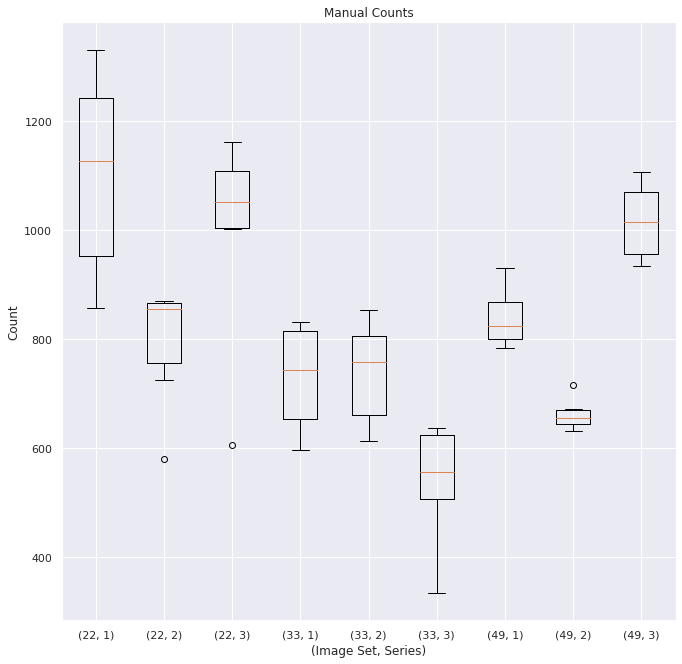

In [30]:
"""
Plot boxplots to show the range of the manual count for each image.
"""

plt.boxplot(manual_counts, labels=manual_counts.index)
plt.title("Manual Counts")
plt.xlabel("(Image Set, Series)")
plt.ylabel("Count")
plt.show()

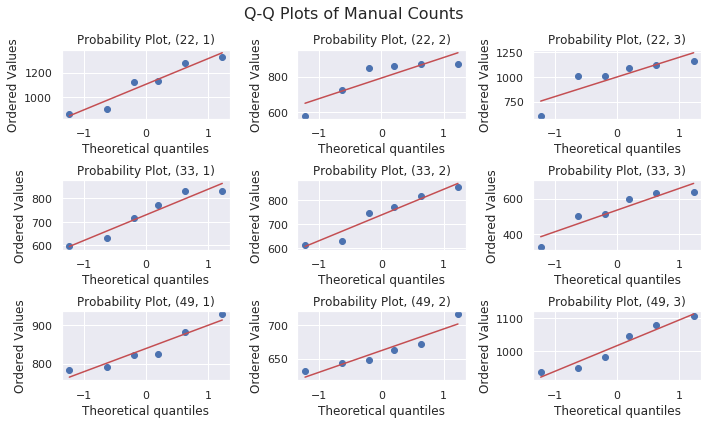

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))

for i in range(len(manual_counts.index)):
    ax = axes[i // 3, i % 3]
    stats.probplot(manual_counts.iloc[i], plot=ax)
    ax.set_title(f"Probability Plot, {manual_counts.index[i]}")
    
fig.suptitle("Q-Q Plots of Manual Counts", size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

Since we have a low dimensional feature space with an underlying distribution that can be assumed to be parametric, we can use Z-score to identify outliers.

Simply, Z-score is a metric that indicates how many standard deviations a data point is from the sample mean. We will discard any data point which have a Z-score greater than 2.5. 

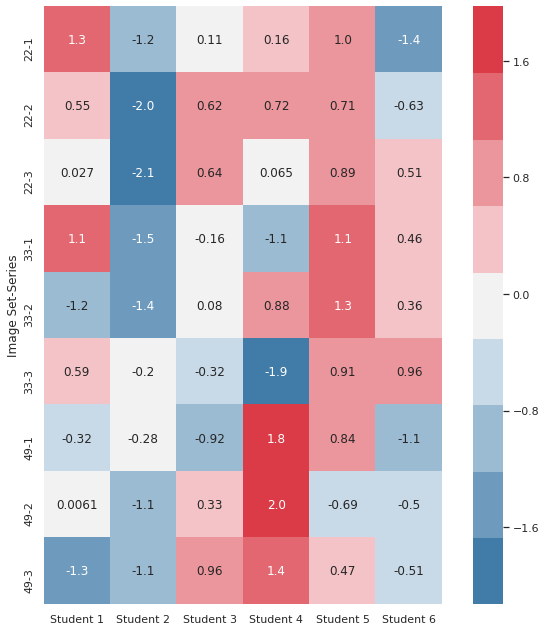

In [32]:
zscores = pd.DataFrame(stats.zscore(manual_counts, axis=1), index=manual_counts.index, columns=manual_counts.columns)

ax = sns.heatmap(zscores, cmap=sns.diverging_palette(240, 10, n=9), annot=True, fmt=".2")
ax.set_aspect("equal")

# y limit workaround for matplotlib - seaborn regression. Details: https://github.com/matplotlib/matplotlib/issues/14675
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

Fortunately, we have no data points that exceed this threshold, so there is no need to discard any values.



In [33]:
mean_manual_counts = pd.DataFrame(manual_counts.mean(axis=1), columns=["Mean Manual Count"])
means = pd.concat([mean_manual_counts, itcn_counts, sc_counts], axis=1)

display(means)

Mean Manual Count  ITCN  SimpleColocalization
Image Set Series                                               
22        1             1103.333333  1250                  1022
          2              792.166667   744                   770
          3              998.000000   812                   960
33        1              729.166667   607                   865
          2              738.833333   798                   738
          3              535.833333   777                   686
49        1              839.500000   795                   785
          2              661.833333   753                   635
          3             1016.500000   874                  1003

Plotting individual manual counts alongside those obtained by each plugin gives an initial sense for how the automated methods fare. Manual counts are plotted in gray, with SimpleColocalization in orange and ITCN in blue.

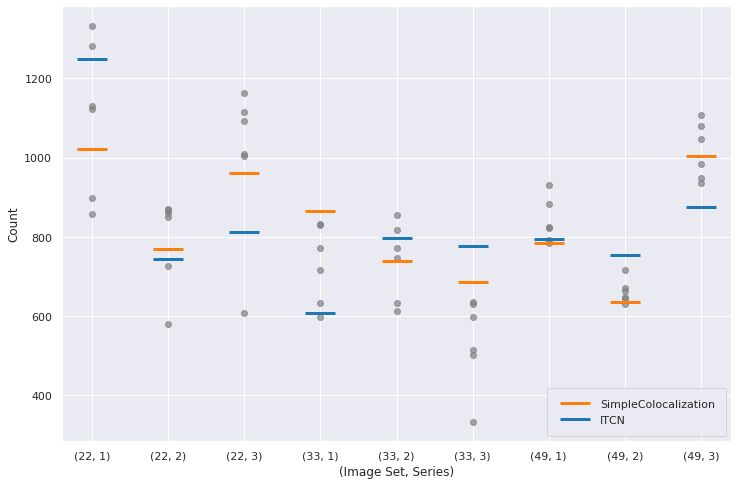

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.canvas.draw()


for i, col in enumerate(manual_counts.columns):
    l = len(manual_counts.columns) / 2
    xs = [x for x in range(9)]
    ys = manual_counts[col]
    plt.plot(xs, ys, marker="o", linestyle="None", color="gray", alpha=0.7)

xs = list(range(9))

plt.plot(xs, all_counts["SimpleColocalization"], marker="_", markersize=30, mew=3, linestyle="None", label="SimpleColocalization", color=SIMPLECOLOCALIZATION_COLOR)
plt.plot(xs, all_counts["ITCN"], marker="_", markersize=30, mew=3, linestyle="None", label="ITCN", color=ITCN_COLOR)

ax.set_xticks(xs)
ax.set_xticklabels(manual_counts.index)
ax.legend(loc="lower right", handlelength=3, borderpad=1)
ax.set_xlabel("(Image Set, Series)")
ax.set_ylabel("Count")
plt.show()

## 3. Performance Analysis

We can perform linear regression to measure the performance of the two plugins.

If a plugin worked perfectly, we would expect the computed counts to match the manual counts exactly, and for the data points to lie on a straight line $y=x$. Therefore, we can measure the deviation from this line to assess accuracy.

Visually, we can see the differences between the two models by plotting them, and comparing them and their errors against a reference line.

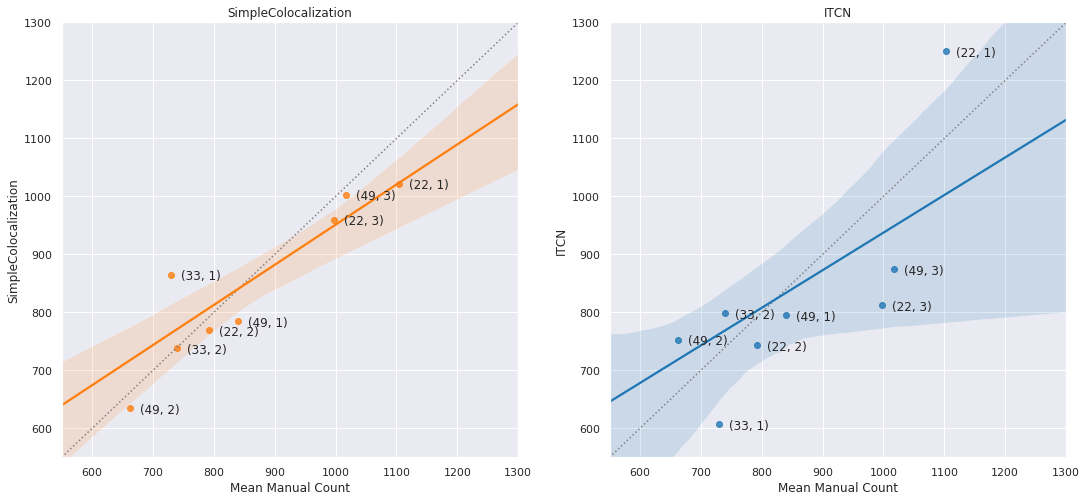

In [35]:
from matplotlib import cm

ITCN_COLOR = "#1f77b4"
SIMPLECOLOCALIZATION_COLOR = "#ff7f0e"

def plot_and_annotate(col1: pd.Series, col2: pd.Series, ax, title=None, color=None):
    """
    Plots two columns of a pandas DataFrame on a scatter graph, and annotates 
    each point with the index of the point.
    
    Pre: col1 and col2 must have the same index.
    """
    sns.regplot(col1, col2, ax=ax, color=color)
    for index, x in col1.iteritems():
        y = col2[index]
        ax.annotate(s=index, xy=(x, y), xytext=(10,-5), textcoords="offset points")
    
    if title is not None:
        ax.set_title(title)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

for ax in axes:
    ax.set_xlabel("Manual Counts")
    ax.set_ylabel("Automated Counts")

    ax.set_xlim([550, 1300])
    ax.set_ylim([550, 1300])

    # Reference line
    ax.plot([550,1300],[550,1300], color="gray", linestyle=":");
    
    
plot_and_annotate(means["Mean Manual Count"], means["SimpleColocalization"], axes[0], title="SimpleColocalization", color=SIMPLECOLOCALIZATION_COLOR)
plot_and_annotate(means["Mean Manual Count"], means["ITCN"], axes[1], title="ITCN", color=ITCN_COLOR)

Immediately, we can see that Simplecolocalization has a better fit to the reference line, and has a consistently smaller error. In particular, ITCN gives wildly inaccurate results for images (22, 1) and (33, 1). SimpleColocalization performs exceptionally well for (22, 1)

Now, to analyse these numerically we first examine whether or not the difference between the two linear regression models is statistically significant.

First we test that the difference in the performance of SimpleColocalization and ITCN is statistically significant. This can be done by performing a [t-test for the regression](http://geog.uoregon.edu/GeogR/topics/interpstats.pdf) of SimpleColocalization and ITCN.

The regression line can be expressed as 
$$Y = \beta_0 + \beta_1 X $$ 
where $B_0$ is a constant and $B_1$ is the slope. From this, we can formulate the hypotheses
$$H_0: B_1 = 0 \\ H_1: B_1 \not= 0$$
The null hypothesis states that the slope is equal to zero, and the alternative hypothesis states that the slope is not equal to zero. We take the significance level $\alpha = 0.05$.

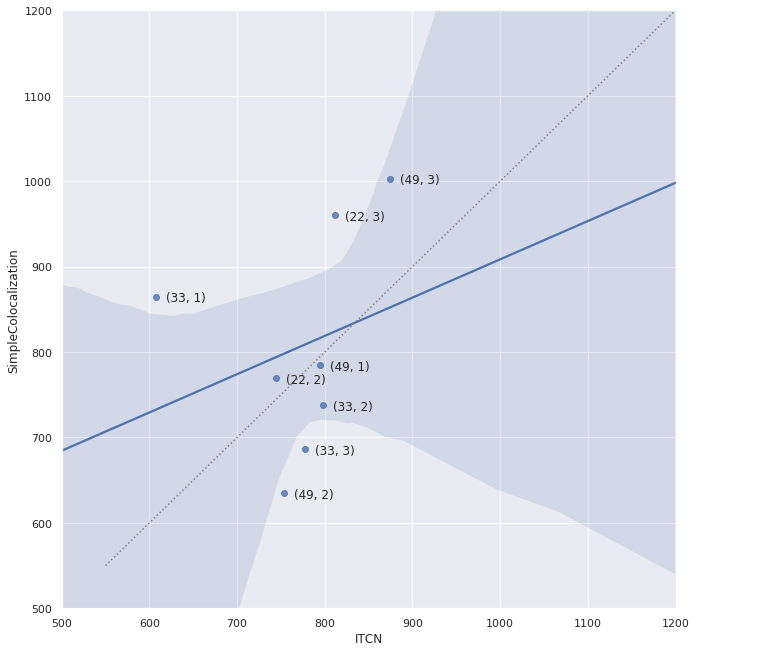

p-value:,0.1169096010465301


In [36]:
fig, ax = plt.subplots()

ax.set_xlim([500, 1200])
ax.set_ylim([500, 1200])

plot_and_annotate(means["ITCN"], means["SimpleColocalization"], ax)

slope, intercept, r_value, p_value, std_err = stats.linregress(means["ITCN"], means["SimpleColocalization"])

ax.plot([550,1200],[550,1200], color="gray", linestyle=":")
plt.show()

display(HTML(f"<table><tr><td>p-value:</td><td>{p_value}</td></tr></table>"))

Since $p > 0.05$ we do not have enough evidence at the $5\%$ significance level to reject the null hypothesis. Hence, we can say that there is a statistically significant difference between the performances of SimpleColocalization and ITCN.

Note that this is equal to the p-value for the F-statistic for a single variable.

In [37]:
# Seaborn does not provide a way to get the regression parameters out, so we recompute it here.

sc_lm = stats.linregress(means["Mean Manual Count"], means["SimpleColocalization"])
itcn_lm = stats.linregress(means["Mean Manual Count"], means["ITCN"])

display(HTML(
    f"""<table>
            <tr>
                <th></th>
                <th>Regression</th>
                <th>Standard Error</th>
                <th>p-value</th>
                <th>MSE</th>
            </tr>
            <tr>
                <td>SimpleColocalization</td>
                <td>$$y = {round(sc_lm.slope, 3)}x + {round(sc_lm.intercept, 3)}$$</td>
                <td>$${round(sc_lm.stderr, 3)}$$</td>
                <td>$${round(sc_lm.pvalue, 5)}$$</td>
            </tr>
            <tr>
                <td>ITCN</td>
                <td>$$y = {round(itcn_lm.slope, 3)}x + {round(itcn_lm.intercept, 3)}$$</td>
                <td>$${round(itcn_lm.stderr, 3)}$$</td>
                <td>$${round(itcn_lm.pvalue, 5)}$$</td>
            </tr>
        </table>"""
))

From the p-values of each model, we can see that they are both statistically signficant in their relationship to the manual counts - and hence the number of cells in each image. To examine the magnitude of the difference, we can turn to looking at the regression coefficents and Mean Squared Error. SimpleColocalization has values for the the coefficients of the linear regression that are closer to $y=x$, and the standard error is also smaller. This suggests that SimpleColocalization gives count values that are closer to those obtained by manual counting.

## 4. Time Efficiency Analysis

An important aspect to the usability and convenience of using an ImageJ plugin is the time it takes to run. Cell counting is a labour-intensive and tedious process, and reducing this time is one of our core goals.

By plotting the time to take manual counts, we can see that it took as long as 20 minutes to count a single image. ITCN runs in less than 15 seconds, and SimpleColocalization in under a single second, opening the door to processing large batches of images in a short amount of time.

In the box plot, the rectangle represents the second and third quartiles, the middle line is the median, and the whiskers show 1.5 IQR. Outlier points are plotted individually. 

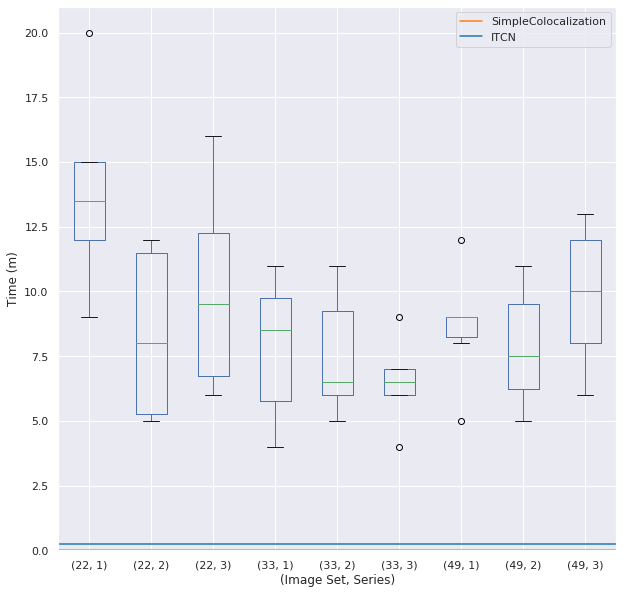

In [38]:
times.T.plot(kind="box", figsize=(10, 10))

# 1 second.
plt.axhline(1/60, label="SimpleColocalization", color=SIMPLECOLOCALIZATION_COLOR)

# 15 seconds.
plt.axhline(15/60, label="ITCN", color=ITCN_COLOR)
plt.legend(loc="upper right")
plt.ylim(0)
plt.xlabel("(Image Set, Series)")
plt.ylabel("Time (m)");

## 5. Conclusion

From the above analysis we can conclude that SimpleColocalization performs better, on average, than ITCN at producing an accurate cell counts in these images of neural tissue. Of course, we cannot assess how accurately each plugin identifies the location of each cell, and this would involve a more sophisticated analysis. 

We are actively working on improving the perfomance and usability of the plugin and there is no doubt still much more to be done here. Our roadmap includes improving the accuracy of cell segmentation using a dip-lining technique, and automatically calculating cell colocalization.